# CH14 Deep Computer Vision Using Convolutional Neural Networks

In [1]:
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Convolutional Layers

In [3]:
from sklearn.datasets import load_sample_images

images = load_sample_images()['images']
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255)(images)

print(images.shape)

(2, 70, 120, 3)


In [4]:
tf.reduce_max(images[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [5]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',activation='relu')
fmaps = conv_layer(images)
print(fmaps.shape)

(2, 70, 120, 32)


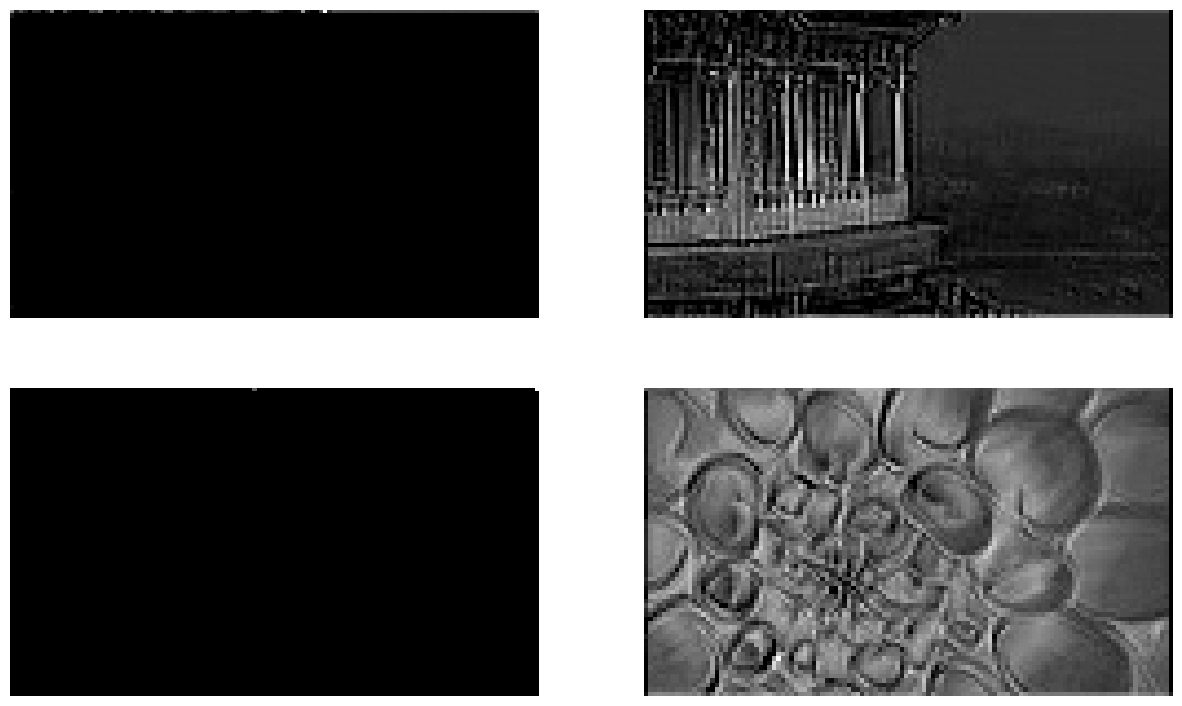

In [6]:
# extra code – displays the two output feature maps for each image

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [7]:
# using strides

conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [8]:
kernels, biases = conv_layer.get_weights()
kernels.shape, biases.shape

((7, 7, 3, 32), (32,))

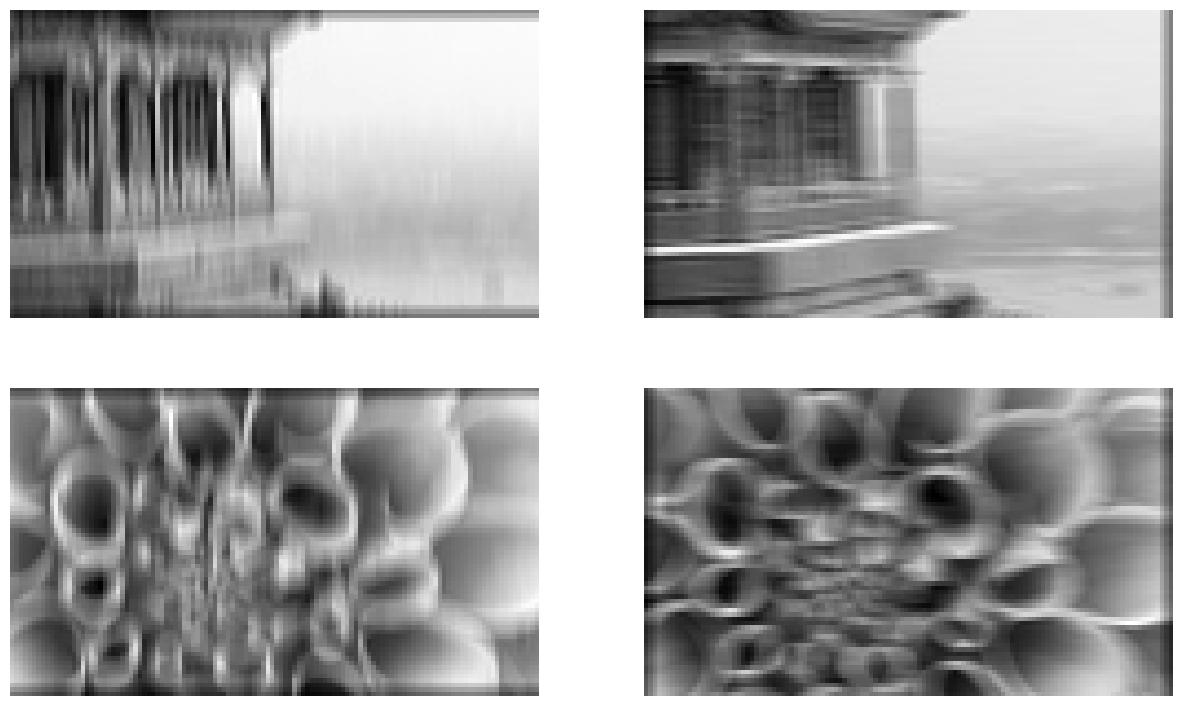

In [9]:
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

### Pooling Layers

In [10]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [11]:
output = max_pool(images)

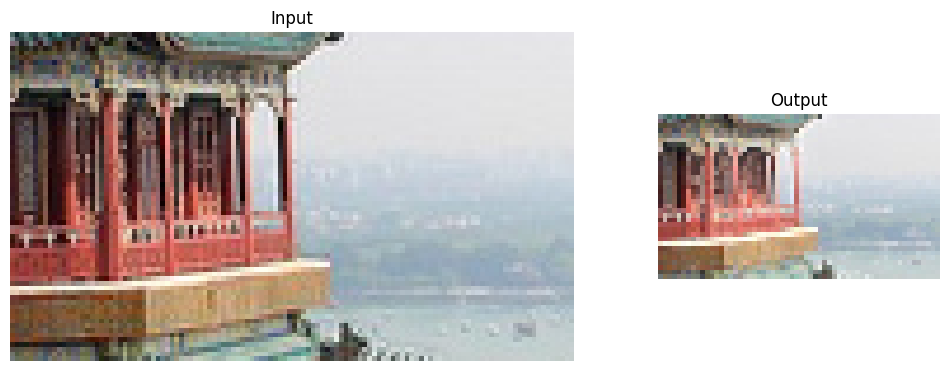

In [12]:
import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [13]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

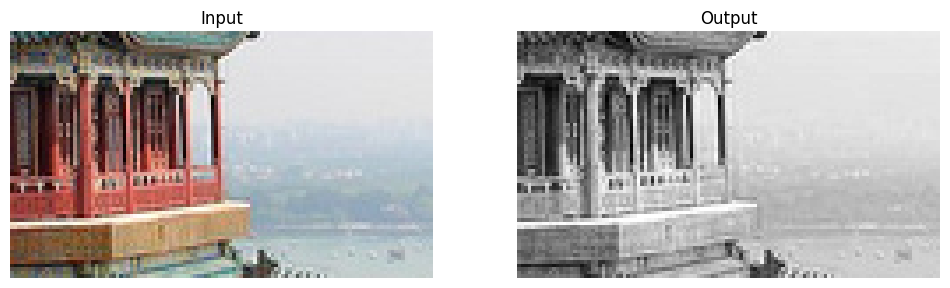

In [14]:
depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

In [15]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
# the same as
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.26010972, 0.10848834]], dtype=float32)>

----

## CNN Architecture

In [16]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
X_train[0].shape, y_train[0]

((28, 28, 1), 9)

In [18]:
from functools import partial

tf.random.set_seed(42)
defualt_conv2d = partial(tf.keras.layers.Conv2D,kernel_size=3,strides=1,
                                        padding='same',activation='relu',kernel_initializer='he_normal')


model = tf.keras.models.Sequential([
  defualt_conv2d(filters=64, kernel_size=7, input_shape=[28,28,1]),
  tf.keras.layers.MaxPool2D(),
  defualt_conv2d(filters=128),
  defualt_conv2d(filters=128),
  tf.keras.layers.MaxPool2D(),
  defualt_conv2d(filters=256),
  defualt_conv2d(filters=256),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=128, activation='relu',kernel_initializer='he_normal'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=64, activation='relu',kernel_initializer='he_normal'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=10, activation='softmax')

 ])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [20]:
history = model.fit(X_train, y_train, epochs=10,validation_data=(X_valid, y_valid),batch_size=256)

Epoch 1/10


I0000 00:00:1728553091.274864      94 service.cc:145] XLA service 0x7bd3b000f9d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728553091.274917      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  9/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1130 - loss: 2.7230

I0000 00:00:1728553096.912316      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1728553096.919888      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3672 - loss: 1.7446

I0000 00:00:1728553105.181654      93 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads



215/215 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.3678 - loss: 1.7427 - val_accuracy: 0.8106 - val_loss: 0.5049
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6940 - loss: 0.8157 - val_accuracy: 0.8582 - val_loss: 0.4144
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7757 - loss: 0.6156 - val_accuracy: 0.8826 - val_loss: 0.3565
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8312 - loss: 0.4913 - val_accuracy: 0.8950 - val_loss: 0.3112
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8565 - loss: 0.4243 - val_accuracy: 0.8974 - val_loss: 0.2957
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8710 - loss: 0.3849 - val_accuracy: 0.9062 - val_loss: 0.2876
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8863 - loss: 0.3368 - val_accuracy: 0.9090 - val_loss: 0.2735
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8969 - loss: 0.3133 - val_accuracy: 0.90

In [21]:
score = model.evaluate(X_test, y_test)
score

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9104 - loss: 0.2973


[0.27764007449150085, 0.9110999703407288]

In [22]:
X_new = X_test[:10]
y_pred = model.predict(X_new)
np.argmax(tf.nn.softmax(y_pred),-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

### Implementing a ResNet-34 CNN Using Keras

In [23]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [24]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit (ResidualUnit)    │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_1 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_2 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_3 (ResidualUnit)  │ (None, 28, 28, 128)    │       230,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_4 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_5 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_6 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_7 (ResidualUnit)  │ (None, 14, 14, 256)    │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_8 (ResidualUnit)  │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_9 (ResidualUnit)  │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_10 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_11 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_12 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_13 (ResidualUnit) │ (None, 7, 7, 512)      │     3,676,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_14 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_15 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,306,826 (81.28 MB)

 Trainable params: 21,289,802 (81.21 MB)

 Non-trainable params: 17,024 (66.50 KB)

### Using Pretrained Models from Keras

In [26]:
model = tf.keras.applications.ResNet50(weights='imagenet')

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
K = tf.keras.backend
images = K.constant(load_sample_images()['images'])
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

In [28]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [29]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


(2, 1000)

In [30]:
top_k = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f'Image #{image_index}')
    for class_id, name, y_proba in top_k[image_index]:
        print(f" {class_id} - {name:12s} {y_proba:.2%}")

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Image #0
 n03877845 - palace       54.69%
 n03781244 - monastery    24.71%
 n02825657 - bell_cote    18.55%
Image #1
 n04522168 - vase         32.67%
 n11939491 - daisy        17.82%
 n03530642 - honeycomb    12.04%


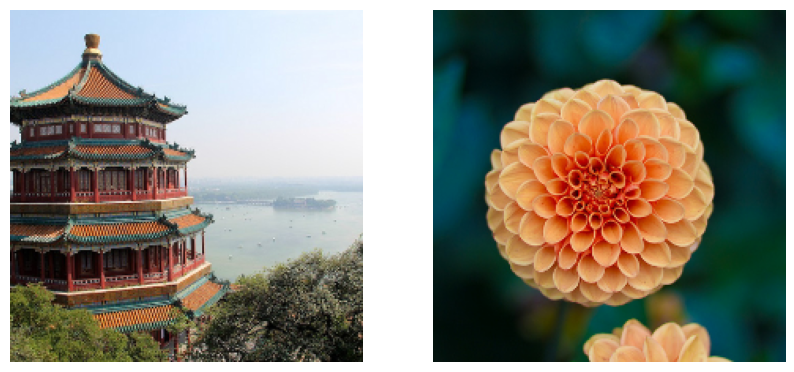

In [31]:
plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

### Pretrained Models for Transfer Learning

In [34]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)
print(info)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/incomplete.TQD6QP_3.0.1/',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/exa

In [35]:
dataset_size = info.splits['train'].num_examples
print(dataset_size)

3670


In [36]:
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

print(class_names)
print(n_classes)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
5


splitting the data into train, valid, test with 75, 15, 10%

In [67]:
train_set, valid_set, test_set = tfds.load('tf_flowers', split=['train[:75%]', 'train[75%:90%]','train[90%:]'],
                                          as_supervised=True)
print(len(train_set), len(valid_set), len(test_set))

2752 551 367


In [68]:
sample_img, sample_label = next(iter(train_set))
print(sample_img.shape, sample_label.shape)

(333, 500, 3) ()


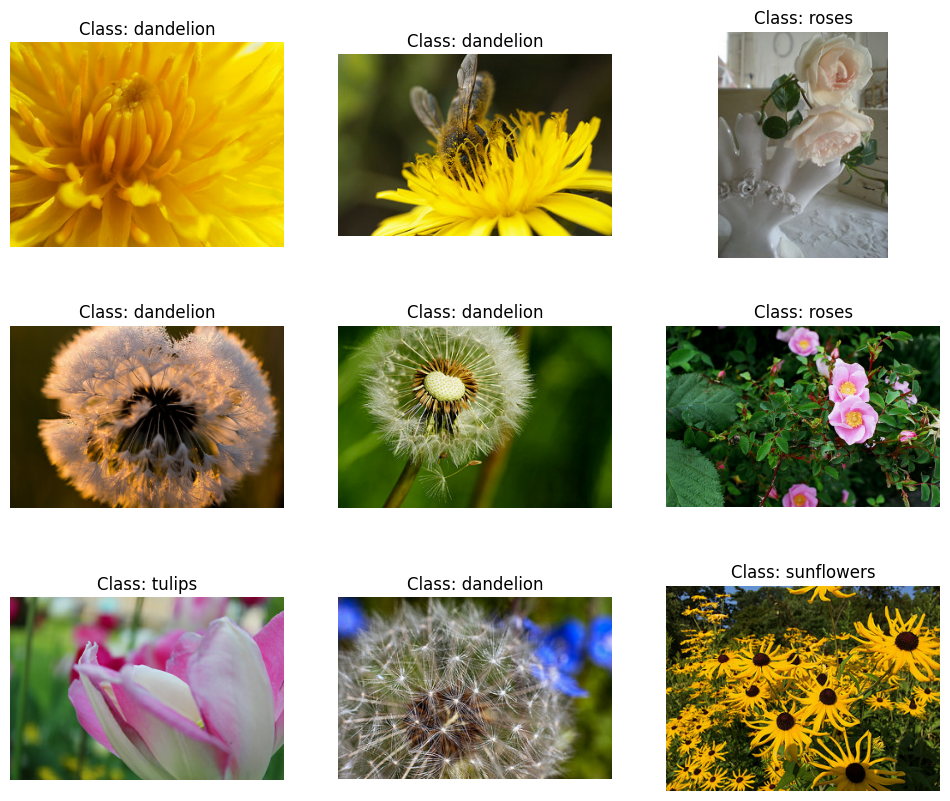

In [69]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

#### Preprocessing

In [70]:
tf.keras.backend.clear_session()

In [71]:
batch_size = 32

preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

train_set = train_set.map(lambda x,y: (preprocess(x),y))
train_set = train_set.shuffle(1_000, seed=42).batch(batch_size).prefetch(1)

valid_set = valid_set.map(lambda x,y: (preprocess(x),y)).batch(batch_size)
test_set = test_set.map(lambda x,y: (preprocess(x),y)).batch(batch_size)

showing the images again after rescaling

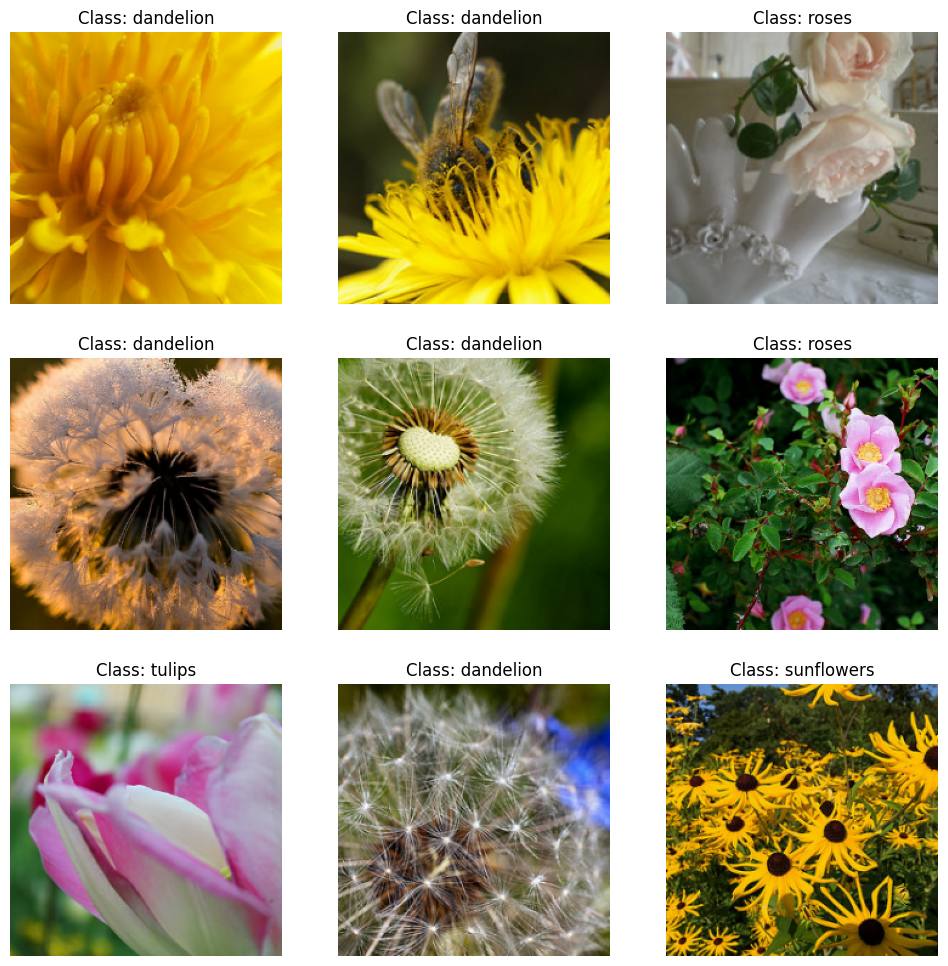

In [72]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

including augmentation :

In [73]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=42),
    tf.keras.layers.RandomRotation(factor=.05, seed=42),
    tf.keras.layers.RandomContrast(factor=.2,seed=42)
])



try augmentation

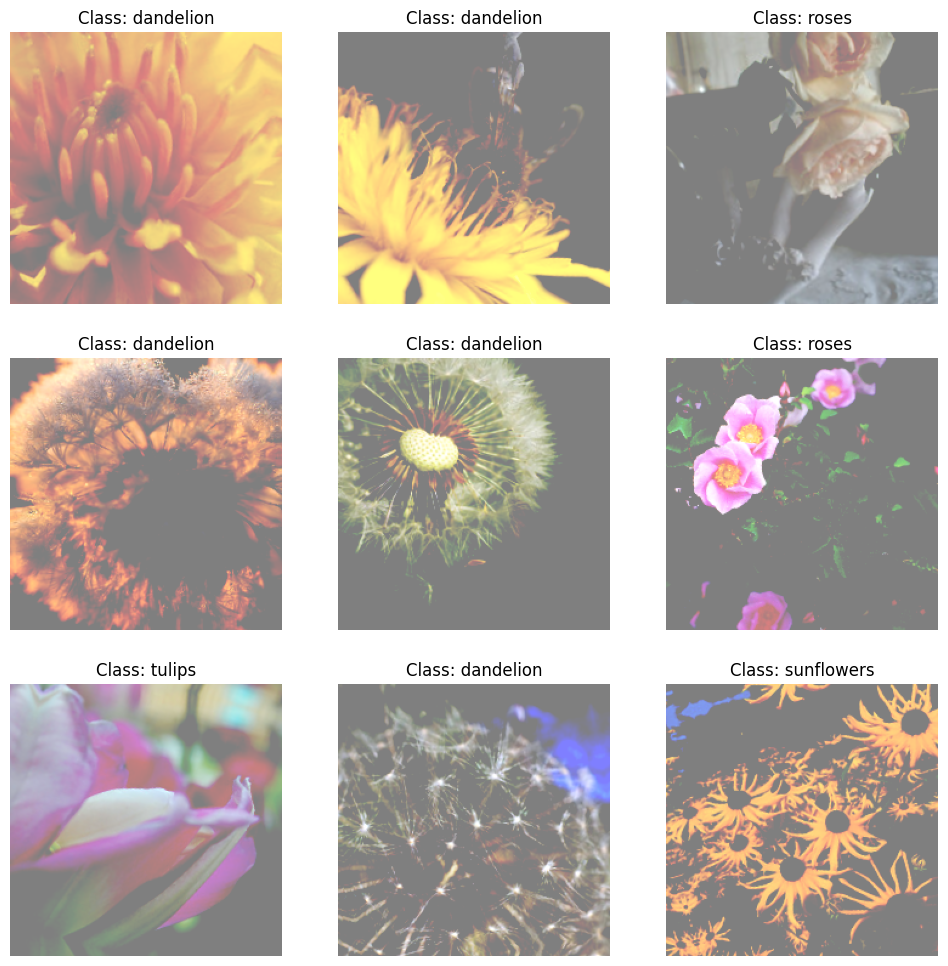

In [78]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [79]:
base_model = tf.keras.applications.Xception(weights='imagenet',include_top=False)

avg_pooling = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation='softmax')(avg_pooling)
model = tf.keras.Model(inputs=base_model.input, outputs = output)

In [80]:
for layer in base_model.layers:
    layer.trainable =False

In [81]:
optim = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=.9)
model.compile(loss= 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
history = model.fit(train_set,epochs=3 ,validation_data=valid_set)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - accuracy: 0.7255 - loss: 0.9838 - val_accuracy: 0.8494 - val_loss: 0.5669
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.8923 - loss: 0.3376 - val_accuracy: 0.8711 - val_loss: 0.4477
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.9295 - loss: 0.2248 - val_accuracy: 0.8929 - val_loss: 0.4706


In [82]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_2          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

here, the top layer we added already trained, the time for unfreezing some layers..

In [83]:
for layer in base_model.layers[56:]:
    layer.trainable =True
    
optim = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=.9)
model.compile(loss= 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

In [84]:
history = model.fit(train_set,epochs=10 ,validation_data=valid_set)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 33s 199ms/step - accuracy: 0.8905 - loss: 0.3361 - val_accuracy: 0.8984 - val_loss: 0.3819
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 0.9821 - loss: 0.0596 - val_accuracy: 0.9183 - val_loss: 0.3001
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 0.9959 - loss: 0.0126 - val_accuracy: 0.9347 - val_loss: 0.2619
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.9978 - loss: 0.0090 - val_accuracy: 0.9292 - val_loss: 0.2753
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 0.9979 - loss: 0.0061 - val_accuracy: 0.9328 - val_loss: 0.2623
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.9984 - loss: 0.0054 - val_accuracy: 0.9274 - val_loss: 0.3485
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 0.9981 - loss: 0.0066 - val_accuracy: 0.9347 - val_loss: 0.2810
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.9992 - loss: 0.0044 - val_accu

### Classification and Localization

In [89]:
import tensorflow as tf

tf.random.set_seed(42)
base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax", name="class_output")(avg)
loc_output = tf.keras.layers.Dense(4, name="loc_output")(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(
    loss=["sparse_categorical_crossentropy", "mse"],  # Classification loss and localization loss
    loss_weights=[0.8, 0.2],  # Adjust the weights depending on the importance of each task
    optimizer=optimizer,
    metrics={"class_output": "accuracy", "loc_output": "mse"}  # Different metrics for each output
)


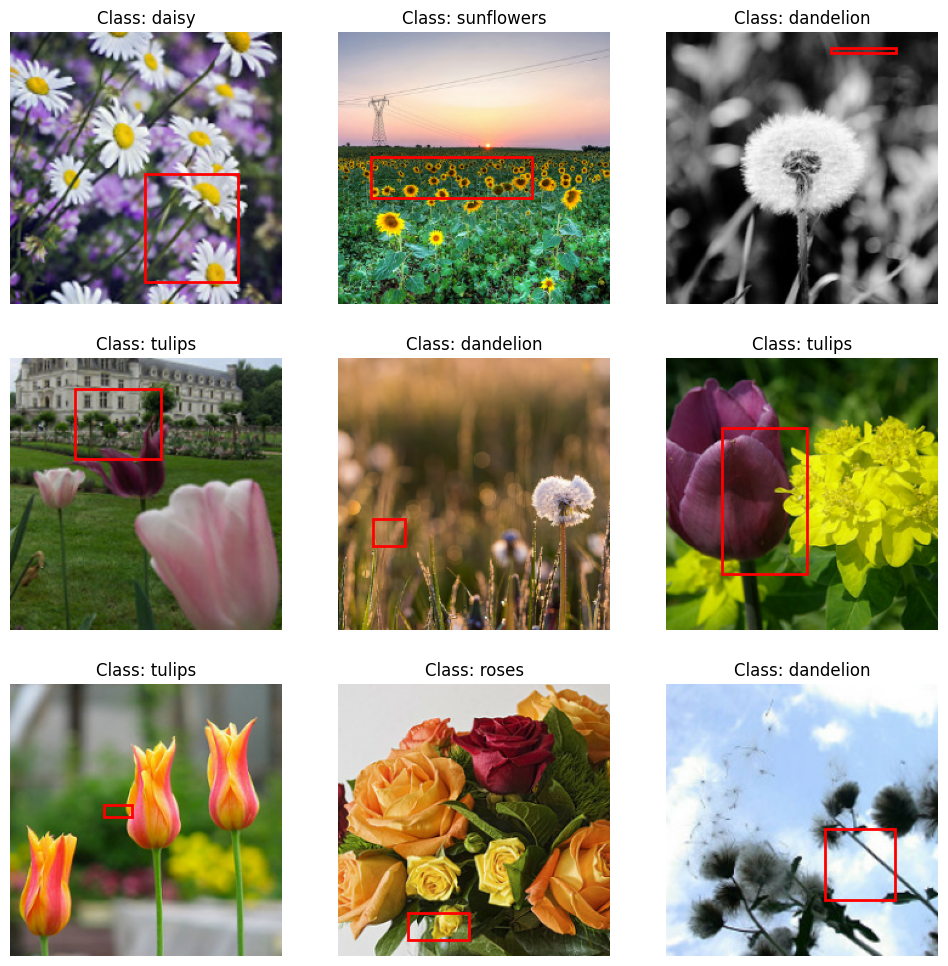

In [86]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4], minval=0, maxval=1)
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

def display_image_with_bbox(image, label, bbox):
    plt.imshow((image + 1) / 2) 
    
    height, width = image.shape[0], image.shape[1]
    xmin, ymin, xmax, ymax = bbox * [width, height, width, height]
    
    # Create a rectangle for the bounding box
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
    plt.gca().add_patch(rect)
    
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.figure(figsize=(12, 12))
for X_batch, (y_batch, bbox_batch) in fake_train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        display_image_with_bbox(X_batch[index], y_batch[index], bbox_batch[index])

plt.show()


In [90]:
model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - class_output_accuracy: 0.3089 - loc_output_mse: 0.3524 - loss: 1.3103
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - class_output_accuracy: 0.6546 - loc_output_mse: 0.1939 - loss: 0.9089
